In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from DataSet import PointDataSet
import random
import math
import tqdm

(array([[ -8.60675  ,  12.702742 ,  -5.3071   ],
       [ -3.700875 ,  -2.3551395, -13.7663   ],
       [ 24.1815   , -19.745598 , -12.309815 ],
       ...,
       [ 14.366826 , -38.578    , -14.755046 ],
       [-14.399642 ,  32.919975 ,  -5.9172   ],
       [ -6.9880977, -38.578    ,  -1.4112417]], dtype=float32), 0)
{0: 'bed', 1: 'monitor', 2: 'desk', 3: 'chair', 4: 'dresser', 5: 'toilet', 6: 'sofa', 7: 'table', 8: 'night_stand', 9: 'bathtub'}


In [2]:
pointData = PointDataSet('ModelNet10/')
print(len(pointData))
print(pointData.class_to_idx)

4899
{'bed': 0, 'monitor': 1, 'desk': 2, 'chair': 3, 'dresser': 4, 'toilet': 5, 'sofa': 6, 'table': 7, 'night_stand': 8, 'bathtub': 9}


## Visualize Data

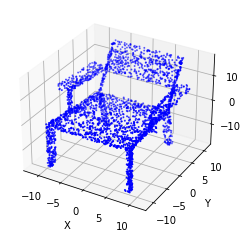

chair


In [3]:
def plot3d(points):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # get xyz coordinate data
  x = points[:, 0]
  y = points[:, 1]
  z = points[:, 2]

  # plot vertices
  ax.scatter(x, y, z, c='b', marker='o', s=1)  # c: 点的颜色，marker: 点的形状，s: 点的大小

  # set axis label
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  plt.show()

points, label = pointData[1878]  
plot3d(points)
print(pointData.idx_to_class[label])

### augment the data

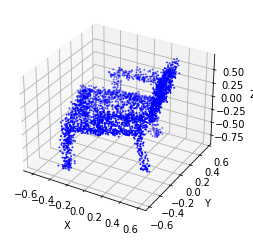

chair


In [4]:
def pre_process(pointcloud, normalize = True, rotation = False, add_noise = True):
    # normalize
    if normalize:
        pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        pointcloud /= np.max(np.linalg.norm(pointcloud, axis=1))

    if rotation:
        # rotation around z-axis
        theta = random.random() * 2. * math.pi # rotation angle
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                            [ math.sin(theta),  math.cos(theta),    0],
                            [0,                             0,      1]])

        pointcloud = rot_matrix.dot(pointcloud.T).T

    if add_noise:
        # add some noise
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

points, label = pointData[1878] 
processed_points = pre_process(points, True, True, True) 
plot3d(processed_points)
print(pointData.idx_to_class[label])

### Load train data and test data

In [5]:
train_ratio = 0.8
test_ratio = 0.2
batch_size = 16

train_size = int(train_ratio * len(pointData))
test_size = len(pointData) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(pointData, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# The MLP Model

In [6]:
class MLPClassifier(nn.Module):
  def __init__(self, input_shape, hidden_dims, num_classes=10, activation = nn.ReLU):
    super(MLPClassifier, self).__init__()
    self.input_shape = input_shape
    self.input_dim = input_shape[0] * input_shape[1]
    self.hidden_dims = hidden_dims
    self.num_classes = num_classes
    self.activation = activation
    self.fc_layers = nn.ModuleList()
    self.build_fc_layers()
      
  def build_fc_layers(self):
    prev_dim = self.input_dim
    for layer_dim in self.hidden_dims:
      self.fc_layers.append(nn.Linear(prev_dim, layer_dim))
      prev_dim = layer_dim
    self.output_layer = nn.Linear(prev_dim, self.num_classes) # output layer

  def forward(self, x):
    x = x.view(-1, self.input_dim)
    for fc_layer in self.fc_layers:
      x = torch.relu(fc_layer(x))
    x = self.output_layer(x)
    x = F.softmax(x, dim=1)
    return x

### Train the simple MLP Classifier

In [7]:
hidden_sizes = [1000, 500, 100]
num_epochs = 100
model = MLPClassifier(input_shape=[3000,3], hidden_dims=hidden_sizes, num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检查是否有可用的 GPU
model.to(device)  # 将模型移动到对应的设备

for epoch in range(num_epochs):
  model.train()  # 将模型设置为训练模式
  for i, (inputs, targets) in enumerate(train_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)  # 将输入和标签移动到对应的设备
    optimizer.zero_grad()  # 清零优化器梯度
    # 前向传播和计算损失
    outputs = model(inputs)
    print(outputs.shape)
    print(targets.shape)
    loss = criterion(outputs, targets)
        
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    
    # 打印训练信息
    if epoch % 5 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_dataloader), loss.item()))

torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [1/245], Loss: 2.3075
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [2/245], Loss: 2.3121
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [3/245], Loss: 2.3099
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [4/245], Loss: 2.1608
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [5/245], Loss: 2.2771
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [6/245], Loss: 2.0635
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [7/245], Loss: 2.0094
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [8/245], Loss: 2.2535
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [9/245], Loss: 2.2004
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [10/245], Loss: 1.8731
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [11/245], Loss: 2.1655
torch.Size([16, 10])
torch.Size([16])
Epoch [1/100], Step [12/245], Loss: 2.2630
torch.Size([16, 10])
torch.Size([16])